# 目的
あるクラウドファンディングが成功するか(state)を事前に予測するモデルを構築する。

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.metrics import log_loss

# データの読み込み

## データの扱いについて
| Variables | 変数 | 使う? | 変数の扱い |
| ---- | ---- | ---- |  ---- |
| ID | internal kickstarter id | - | - |
| name | プロジェクト名 | - | - |
| category | カテゴリー | ○ | ダミー変数 |
| main_category | category of campaign | ○ | ダミー変数 |
| currency | 通貨 | ○ | ダミー変数 |
| deadline | 期限 | ○ (開始日 - 期限 の募集機関で使ってみる) | 数値(日数) |
| goal | 目標金額 | ○ | 数値(金額) |
| launched | 開始日 | ○ (開始日 - 期限 の募集機関で使ってみる) | 数値(日数) |
| pledged | 集まった金額 | - (開始時にはわからないので使わない) | - |
| state | 成否 | ※目的変数 | fiailled: 0, successful: 1, Other: 捨てる(Pandasで) |

↓必要な項目を抜き出して読み込み、データの整形を行う。

In [71]:
ks_projects_data = pd.read_csv("ks-projects-201801.csv")[['category', 'main_category', 'currency', 'deadline', 'goal', 'launched', 'state']]

# state が failed と successful 以外の行を削除 
# SettingWithCopyWarningがでるので copy() する
# indexが連番じゃなくなるので reset_index() で連番に直す
ks_projects_data2 = ks_projects_data[(ks_projects_data['state'] == 'failed') | (ks_projects_data['state'] == 'successful')].copy().reset_index(drop=True)

# 欠損値が無いことを確認
#ks_projects_data2.info()

# deadline - launched で募集期間を算出する
# pd.to_datetime() を使って、str を datetime64型に変換
# 日数(int)で出したいので、Series.dt() を使って変換
ks_projects_data2['launched'] = pd.to_datetime(ks_projects_data2['launched'], format='%Y-%m-%d %H:%M:%S')
ks_projects_data2['deadline'] = pd.to_datetime(ks_projects_data2['deadline'], format='%Y-%m-%d %H:%M:%S')
ks_projects_data2['duration'] = (ks_projects_data2['deadline'] - ks_projects_data2['launched']).dt.days

#display(ks_projects_data2.head())

# currency を USD に統一する
# 為替レートはみずほ銀行のサイトから取得した
exchange_rate = pd.read_csv("m_quote.csv")[['Date', 'AUD', 'CAD', 'CHF', 'DKK', 'EUR', 'GBP', 'HKD', 'MXN', 'NOK', 'NZD', 'SEK', 'SGD', 'USD']]
exchange_rate['Date'] = pd.to_datetime(exchange_rate['Date'], format='%Y/%m/%d').dt.strftime('%Y/%m')
exchange_rate = exchange_rate.set_index('Date')

# ks_projects_data2['deadline'] を年月だけにする
ks_projects_data2['deadline'] = ks_projects_data2['deadline'].dt.strftime('%Y/%m')

# ks_projects_data2へUSD列を追加して、為替から計算する
ks_projects_data2['goal_USD'] = 0

# 時間がかかるので map()を使うように直したい。後で考える。
for i in range(len(ks_projects_data2.index)):
    if ks_projects_data2.loc[i, 'currency'] == 'USD':
        ks_projects_data2.loc[i, 'goal_USD'] = ks_projects_data2.loc[i, 'goal']
    elif ks_projects_data2.loc[i, 'currency'] == 'JPY':
        ks_projects_data2.loc[i, 'goal_USD'] = ks_projects_data2.loc[i, 'goal'] / exchange_rate.loc[ks_projects_data2.loc[i, 'deadline'], 'USD']
    else:
        ks_projects_data2.loc[i, 'goal_USD'] = ks_projects_data2.loc[i, 'goal'] * exchange_rate.loc[ks_projects_data2.loc[i, 'deadline'], ks_projects_data2.loc[i, 'currency']] / exchange_rate.loc[ks_projects_data2.loc[i, 'deadline'], 'USD']


# category, launched, deadline, currency, goalを外す
# categoryは種類が多すぎてメモリに載らないので、一旦省いて考える。
ks_projects_data3 = ks_projects_data2.drop(['category', 'launched', 'deadline', 'currency', 'goal'], axis=1)
#display(ks_projects_data3.head())

# state を succesful = 1, failed = 0 に置換する
ks_projects_data3 = ks_projects_data3.replace({'state': {'failed': 0, 'successful': 1}})
#display(ks_projects_data3.head())

# 質的変数(category, main_category, currency) のユニークな値の確認
# categoryの種類が多すぎてメモリに載らないため、一旦 category を外して考える
#ks_projects_data2['currency'].value_counts()  # 14
#ks_projects_data2['category'].value_counts()  # かなり多い
#ks_projects_data2['main_category'].value_counts()  # 15

# main_category と currency をダミー変数に変換する
ks_projects_data4 = pd.get_dummies(ks_projects_data3)
display(ks_projects_data4.head())


,state,duration,goal_USD,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,0,58,1532.39507,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,59,30000.00000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,44,45000.00000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,29,5000.00000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1,34,50000.00000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


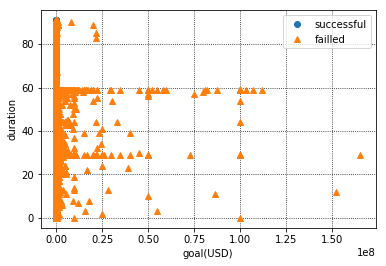

In [83]:
# グラフ描画
# 成功と失敗で DataFrameを分ける
ks_projects_data4_successful = ks_projects_data4[(ks_projects_data4['state'] == 1)].copy().reset_index(drop=True)
ks_projects_data4_failled = ks_projects_data4[(ks_projects_data4['state'] == 0)].copy().reset_index(drop=True)

# 説明変数は duration, goal_USD, main_category
# まずは duration と goal_USD をプロットする
# グラフが被ってよくわからない。。。
plt.plot(ks_projects_data4_successful['goal_USD'], ks_projects_data4_successful['duration'], 'o', label='successful')
plt.plot(ks_projects_data4_failled['goal_USD'], ks_projects_data4_failled['duration'], '^', label='failled')
plt.xlabel("goal(USD)")
plt.ylabel("duration")
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.legend(loc='best')
plt.show()


In [74]:
# numpy配列に変換
y = ks_projects_data4['state'].values
X = ks_projects_data4.drop('state', axis=1).values

clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
clf.fit(X, y)

# 重みを取得して表示
w0 = clf.intercept_[0]
print("w0 = {:.3f}".format(w0))

wn = []
for i in range(len(clf.coef_[0])):
    wn.append(clf.coef_[0,i])
    print("w{} = {:.3f}".format(i+1, wn[i]))

w0 = 7040.970
w1 = 163512.908
w2 = -38540.313
w3 = 467.402
w4 = 533.948
w5 = -261.375
w6 = 231.042
w7 = 962.280
w8 = -171.760
w9 = 1813.977
w10 = -21.545
w11 = 1033.645
w12 = -127.858
w13 = 1873.919
w14 = -42.211
w15 = -3.331
w16 = 110.279
w17 = 642.556


In [82]:
# ラベルを予測
y_est = clf.predict(X)

# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est)))

# 正答率を表示
print('正答率(Accuracy) = {:.3f}%'.format(100 * accuracy_score(y, y_est)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score,_ = precision_recall_fscore_support(y, y_est)

print('適合率(Precision) = {:.3f}%'.format(100 * precision[0]))
print('再現率(Recall) = {:.3f}%'.format(100 * recall[0]))
print('F1値(F1-score) = {:.3f}%'.format(100 * f1_score[0]))




対数尤度 = -13.885
正答率(Accuracy) = 59.799%
適合率(Precision) = 59.855%
再現率(Recall) = 98.884%
F1値(F1-score) = 74.572%


In [85]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_est),
                        index = ['正解 = 失敗', '正解 = 成功'],
                        columns = ['予測 = 失敗', '予測 = 成功'])

display(conf_mat)
#sns.heatmap(conf_mat)
#plt.show()

,予測 = 失敗,予測 = 成功
正解 = 失敗,195513,2206
正解 = 成功,131130,2826
